# Adaptive Safety Verification for the Inverted Pendulum

Determine the largest safe set for a GP model of the inverted pendulum with an adaptive discretization.

In [1]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
import gpflow
import safe_learning
import matplotlib.pyplot as plt
import time
import os

from scipy.linalg import block_diag
from utilities import InvertedPendulum, binary_cmap

# Nice progress bars
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

_STORAGE = {}

HEAT_MAP = plt.get_cmap('inferno', lut=None)
HEAT_MAP.set_over('white')
HEAT_MAP.set_under('black')

LEVEL_MAP = plt.get_cmap('viridis', lut=21)
LEVEL_MAP.set_over('gold')
LEVEL_MAP.set_under('white')



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## User Options

In [2]:
class Options(object):
    def __init__(self, **kwargs):
        super(Options, self).__init__()
        self.__dict__.update(kwargs)

OPTIONS = Options(np_dtype              = safe_learning.config.np_dtype,
                  tf_dtype              = safe_learning.config.dtype,
                  saturate              = True,                            # apply saturation constraints to the control input
                  eps                   = 1e-8,                            # numerical tolerance
                  use_linear_dynamics   = False,                           # use the linearized form of the dynamics as the true dynamics (for testing)
                  use_lipschitz_scaling = True,                            # use different Lipschitz constants in each state for the Lyapunov function
                  use_zero_threshold    = False,                           # assume the discretization is infinitely fine (i.e., tau = 0; for testing)
                  use_true_parameters   = False,                           # use the true physical parameters in the GP model (for testing)
                  use_linear_kernels    = False,                           # use only linear kernels in the GP model
                  use_adaptive_grid     = True,                            # use an adaptive discretization for safety verification
                  gp_confidence_scaling = 2.,                              # scaling factor for GP confidence intervals (i.e., beta)
                  gp_noise_variance     = 0.001 ** 2,                      # noise variance used in GP model
                  gp_num_scaling        = 1.,                              # internal scaling factor for better numerical stability in GP prediction
                  dpi                   = 200,
                  num_cores             = 4,
                  num_sockets           = 1)


## TensorFlow Session

Customize the TensorFlow session for the current device.

In [3]:
os.environ["KMP_BLOCKTIME"]    = str(0)
os.environ["KMP_SETTINGS"]     = str(1)
os.environ["KMP_AFFINITY"]     = 'granularity=fine,noverbose,compact,1,0'
os.environ["OMP_NUM_THREADS"]  = str(OPTIONS.num_cores)

config = tf.ConfigProto(intra_op_parallelism_threads  = OPTIONS.num_cores,
                        inter_op_parallelism_threads  = OPTIONS.num_sockets,
                        allow_soft_placement          = False,
                        device_count                  = {'CPU': OPTIONS.num_cores})

try:
    session.close()
except NameError:
    pass
session = tf.InteractiveSession(config=config)


## Dynamics

Define the nonlinear and linearized forms of the inverted pendulum dynamics.

In [4]:
# Constants
dt = 0.01   # sampling time
g = 9.81    # gravity

# True system parameters
m = 0.15    # pendulum mass
L = 0.5     # pole length
b = 0.1     # rotational friction

# State and action normalizers
theta_max = np.deg2rad(30)                 # angular position [rad]
omega_max = np.sqrt(g / L)                 # angular velocity [rad/s]
u_max     = g * m * L * np.sin(theta_max)  # torque [N.m], control action

state_norm  = (theta_max, omega_max)
action_norm = (u_max,)

# Dimensions and domains
state_dim     = 2
action_dim    = 1
state_limits  = np.array([[-1., 1.]] * state_dim)
action_limits = np.array([[-1., 1.]] * action_dim)

# True system
true_pendulum = InvertedPendulum(m, L, b, dt, [state_norm, action_norm])
A_true, B_true = true_pendulum.linearize()

if OPTIONS.use_linear_dynamics:
    true_dynamics = safe_learning.functions.LinearSystem((A_true, B_true), name='true_dynamics')
else:
    true_dynamics = true_pendulum.__call__

if not OPTIONS.use_true_parameters:
    # "Wrong" system
    m = 0.1     # pendulum mass
    L = 0.4     # pole length
    b = 0.0     # rotational friction
pendulum = InvertedPendulum(m, L, b, dt, [state_norm, action_norm])
A, B = pendulum.linearize()


## GP Model

Define a GP model with possibly wrong physical parameters.

In [5]:
# Prior variances; make sure at least some non-zero value is maintained
M_true = np.hstack((A_true, B_true))
M = np.hstack((A, B))
prior_variances = (M_true - M) ** 2
np.clip(prior_variances, 1e-3, None, out=prior_variances)

# Input to GP is of the form (x, u) = (state, action)
full_dim = state_dim + action_dim

# Kernels
if OPTIONS.use_linear_kernels:
    kernel_theta = gpflow.kernels.Linear(full_dim, variance=prior_variances[0, :], ARD=True)
    kernel_omega = gpflow.kernels.Linear(full_dim, variance=prior_variances[1, :], ARD=True)
else:
    kernel_theta = (gpflow.kernels.Linear(full_dim, variance=prior_variances[0, :], ARD=True)
                    + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
                    * gpflow.kernels.Linear(1, variance=prior_variances[0, 1]))
    kernel_omega = (gpflow.kernels.Linear(full_dim, variance=prior_variances[1, :], ARD=True)
                    + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
                    * gpflow.kernels.Linear(1, variance=prior_variances[1, 1]))

# Use linearized form for the mean dynamics
mean_function_theta = safe_learning.LinearSystem((A[[0], :], B[[0], :]), name='mean_dynamics_theta')
mean_function_omega = safe_learning.LinearSystem((A[[1], :], B[[1], :]), name='mean_dynamics_omega')

# TODO Tensorflow may spit out a lot of allocator errors when creating 0-length dataholders in gpflow, e.g., when:
#     - initializing with empty data matrices X and Y, or
#     - using GPRCached (initializes empty dataholders for Cholesky decomposition)

# X_init = np.empty((0, full_dim), dtype=OPTIONS.np_dtype)
# Y_init = np.empty((0, 1), dtype=OPTIONS.np_dtype)
# gp_theta = safe_learning.GPRCached(X_init, Y_init, kernel_theta, mean_function_theta, OPTIONS.gp_num_scaling)
# gp_omega = safe_learning.GPRCached(X_init, Y_init, kernel_omega, mean_function_omega, OPTIONS.gp_num_scaling)

# Define a GP model over the dynamics
X_init   = np.zeros((1, full_dim), dtype=OPTIONS.np_dtype)
Y_init   = np.zeros((1, 1), dtype=OPTIONS.np_dtype)

gp_theta = gpflow.gpr.GPR(X_init, Y_init, kernel_theta, mean_function_theta)
gp_omega = gpflow.gpr.GPR(X_init, Y_init, kernel_omega, mean_function_omega)

gp_theta.likelihood.variance = OPTIONS.gp_noise_variance
gp_omega.likelihood.variance = OPTIONS.gp_noise_variance

gp_theta_fun = safe_learning.GaussianProcess(gp_theta, OPTIONS.gp_confidence_scaling)
gp_omega_fun = safe_learning.GaussianProcess(gp_omega, OPTIONS.gp_confidence_scaling)

# Stack GP functions to get a block-diagonal kernel matrix, which yields more efficient GP prediction
dynamics = safe_learning.FunctionStack((gp_theta_fun, gp_omega_fun))


/app/safe_learning/functions.py:1563: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.matrix = np.hstack(map(fun, matrices))


## State Discretization and Initial Safe Set

Define a possibly adaptive discretization, and an initial known safe set as a subset of this discretization.

In [6]:
# Number of states along each dimension
if OPTIONS.use_adaptive_grid:
    num_states = 501
else:
    num_states = 3001

# State grid
grid_limits = np.array([[-1., 1.], ] * state_dim)
grid = safe_learning.GridWorld(grid_limits, num_states)

# Discretization constant
if OPTIONS.use_zero_threshold:
    tau = 0.0
else:
    tau = np.sum(grid.unit_maxes) / 2

print('Grid size: {}'.format(grid.nindex))
print('Discretization constant (tau): {}'.format(tau))

# Set initial safe set as a ball around the origin (in normalized coordinates)
cutoff_radius    = 0.2
initial_safe_set = np.linalg.norm(grid.all_points, ord=2, axis=1) <= cutoff_radius


Grid size: 251001
Discretization constant (tau): 0.004


/app/safe_learning/functions.py:635: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points = np.column_stack(col.ravel() for col in mesh)


## Fixed Policy

Fix the policy to the LQR solution for the linearized, discretized, true system, possibly with saturation constraints.

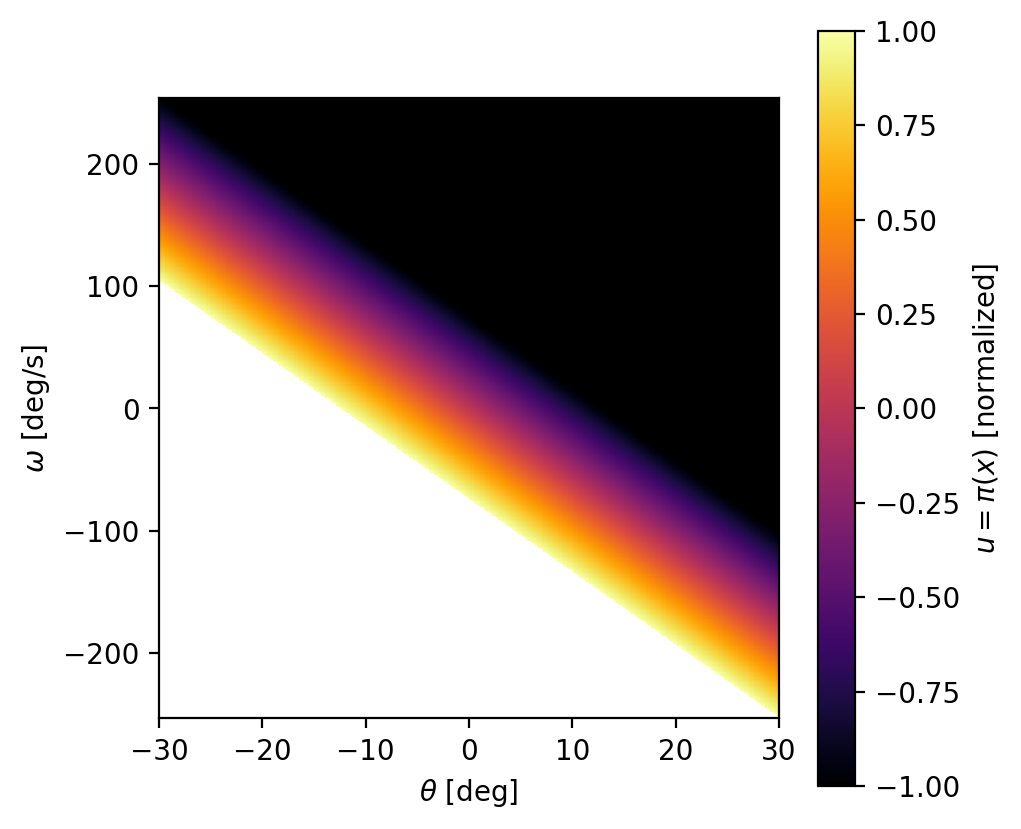

In [7]:
Q = np.diag([1., 2.]).astype(OPTIONS.np_dtype)                # state cost matrix
R = 1.2 * np.identity(action_dim).astype(OPTIONS.np_dtype)    # action cost matrix
K, P = safe_learning.utilities.dlqr(A_true, B_true, Q, R)
P /= np.abs(P).max()                                          # normalize cost

policy = safe_learning.LinearSystem(-K, name='policy')
if OPTIONS.saturate:
    policy = safe_learning.Saturation(policy, -1, 1)

# Visualize policy
def plot_policy(policy, grid, norms, tol=1e-10):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=OPTIONS.dpi)
    ticks = np.linspace(-1., 1., 9)
    cutoff = 1. - tol
    plot_limits = np.asarray(norms).reshape((-1, 1)) * grid.limits
    
    z = policy(grid.all_points).eval().reshape(grid.num_points)
    im = ax.imshow(z.T, origin='lower', extent=plot_limits.ravel(), aspect=plot_limits[0, 1] / plot_limits[1, 1], cmap=HEAT_MAP, vmin=-cutoff, vmax=cutoff)
    cbar = fig.colorbar(im, ax=ax, label=r'$u = \pi(x)$ [normalized]', ticks=ticks)
    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$\omega$ [deg/s]')
    plt.show()


norms = np.rad2deg(state_norm)
plot_policy(policy, grid, norms)


## Closed-Loop Dynamics Lipschitz Constant

In [8]:
# Policy (linear)
L_pol = np.linalg.norm(-K, 1)

# Dynamics (linear approximation)
L_dyn = np.linalg.norm(A_true, 1) + np.linalg.norm(B_true, 1) * L_pol


## Fixed Lyapunov Function

Fix the Lyapunov function to the LQR solution for the linearized, discretized, true system.

In [9]:
# Define the Lyapunov function corresponding to the LQR policy
lyapunov_function = safe_learning.QuadraticFunction(P)

# Approximate local Lipschitz constants with gradients
grad_lyapunov_function = safe_learning.LinearSystem((2 * P,))
if OPTIONS.use_lipschitz_scaling:
    L_v = lambda x: tf.abs(grad_lyapunov_function(x))
else:
    L_v = lambda x: tf.norm(grad_lyapunov_function(x), ord=1, axis=1, keep_dims=True)

# Initialize class (with a possibly adaptive discretization for safety verification)
lyapunov = safe_learning.Lyapunov(grid, lyapunov_function, dynamics, L_dyn, L_v, tau, policy, initial_safe_set, adaptive=OPTIONS.use_adaptive_grid)
lyapunov.update_values()
lyapunov.update_safe_set()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## TensorFlow Graph

In [10]:
# Current
states = tf.placeholder(OPTIONS.tf_dtype, shape=[None, grid.ndim], name='states')
actions = policy(states)
values = lyapunov.lyapunov_function(states)

# Predicted future
future_states_mean, future_states_error = lyapunov.dynamics(states, actions)
future_values_mean = lyapunov.lyapunov_function(future_states_mean)
lv = lyapunov.lipschitz_lyapunov(future_states_mean)
future_values_error = tf.reduce_sum(lv * future_states_error, axis=1, keepdims=True)
dv_mean = future_values_mean - values
dv_bound = dv_mean + future_values_error

# True future
future_states = true_dynamics(states, actions)
future_values = lyapunov.lyapunov_function(future_states)
dv = future_values - values

# Discretization effects
tau = tf.placeholder(OPTIONS.tf_dtype, shape=[None, 1], name='discretization_constant')
threshold = lyapunov.threshold(states, tau)
negative = tf.less(dv_bound, threshold)


## Visualize Discretization Effects

The tightened Lyapunov stability certificate $\Delta v({\bf x}) := v(f_\pi({\bf x})) - v({\bf x}) < - L_{\Delta v}\tau$ becomes easier to satisfy as the grid is refined (i.e., as the spacing $\tau$ decreases). However, this creates more states that must be verified within any level set due to the curse of dimensionality. For a given uniform grid with a side length of $M$ cells, $\Delta v({\bf x}) < - L_{\Delta v}\tau$ may not be satisfied, but 
    $$\Delta v({\bf x}) < - L_{\Delta v}\frac{\tau}{N({\bf x})}$$ 
may be, where $N({\bf x}) \in \mathbb{N}_{\geq 1}$ represents an adaptive refinement of the grid cell centred at $\bf{x}$. This new condition would need to be checked at the $N({\bf x})^d$ additional grid points created around $\bf x$. We visualize the required refinement $N(\bf{x})$ when beginning with a uniform square (i.e., $M^d$-sized) grid for the true dynamics below.

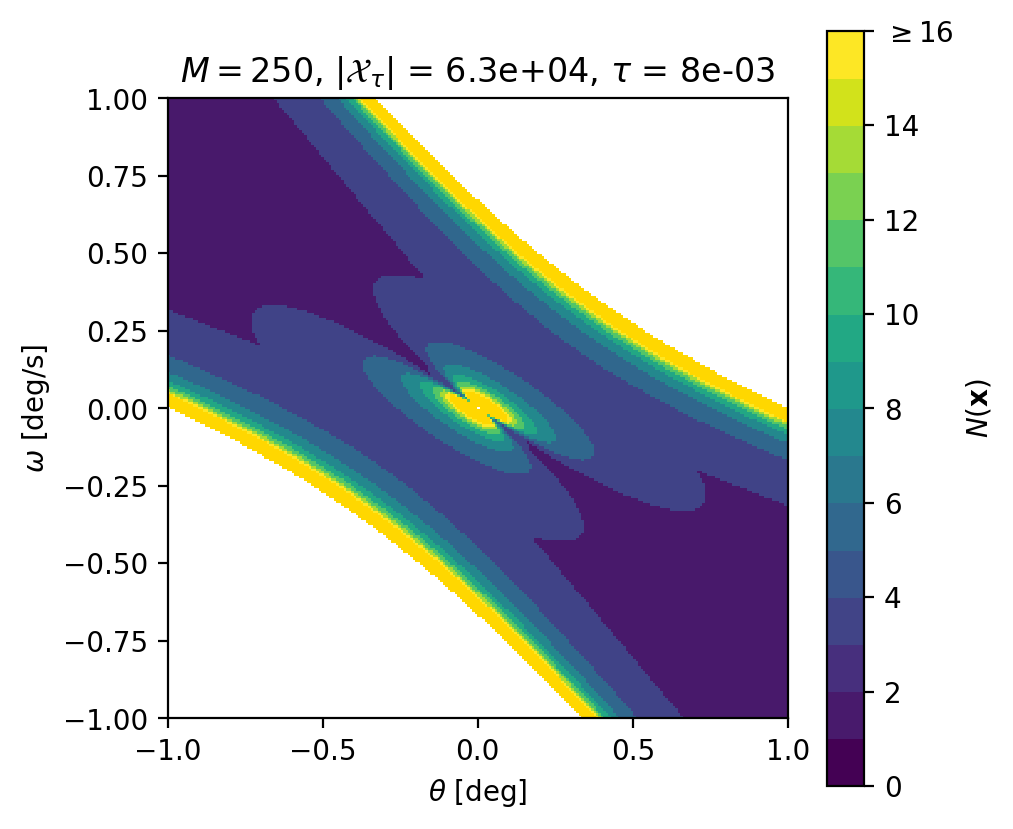

In [11]:
# Adjust this parameter to see the effect of different uniform discretizations, and the required adaptive refinement. 
cells_per_side = 250

# Initialize a uniform square grid
grid_limits = np.array([[-1., 1.], ] * state_dim)
grid = safe_learning.GridWorld(grid_limits, cells_per_side + 1)
grid_spacing = np.sum(grid.unit_maxes) / 2

# Create a colormap for N(x)
N_max = 16
cmap = plt.get_cmap('viridis', lut=N_max)
cmap.set_over('gold')
cmap.set_under((1., 1., 1., 0.))

# Compute the required refinement N(x) for the adaptive discretization; if dv >= 0, then no amount of refinement will help, so we set N(x) = -1 (white) for plotting
feed_dict = {states: grid.all_points, tau: [[np.sum(grid.unit_maxes) / 2]]}
N = (threshold / dv).eval(feed_dict)
N[np.isnan(N)] = -1
N[N < 0] = -1
N = np.ceil(N)

# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=OPTIONS.dpi)

z = N.reshape(grid.num_points)
im = ax.imshow(z.T, origin='lower', extent=grid_limits.ravel(), aspect=grid_limits[0, 1] / grid_limits[1, 1], cmap=cmap, vmin=0, vmax=N_max)
cbar = fig.colorbar(im, ax=ax, label=r'$N({\bf x})$', ticks=np.arange(0, N_max + 1, 2))
ax.set_title(r'$M = {}$'.format(grid.num_points[0] - 1) 
             + ', ' + r'$|\mathcal{X}_\tau|$ = ' + r'{:.1e}'.format(grid.nindex) 
             + ', ' + r'$\tau$ = ' + r'{:.0e}'.format(grid_spacing), 
             )
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\omega$ [deg/s]')

yticks = cbar.ax.get_yticks()
tick_labels = ['{:.0f}'.format(y * N_max) for y in yticks]
tick_labels[-1] = r'$\geq {}$'.format(N_max)
cbar.ax.set_yticklabels(tick_labels)

plt.show()


## Safe Online Learning and Exploration

Only visit certified safe states in order to obtain measurements and update the GP model of the dynamics.

In [12]:
# We are not updating the policy, so do not consider perturbations around the current policy
action_variation = np.array([[0.]], dtype=OPTIONS.np_dtype)

with tf.name_scope('add_new_measurement'):
    full_dim = state_dim + action_dim 
    tf_max_state_action = tf.placeholder(OPTIONS.tf_dtype, shape=[1, full_dim])
    tf_measurement = true_dynamics(tf_max_state_action)
    
def update_gp():
    """Update the GP model based on an actively selected data point."""
    
    # Get a new sample location
    max_state_action, _ = safe_learning.get_safe_sample(lyapunov, action_variation, action_limits, positive=True, num_samples=1000)
    
    # Obtain a measurement of the true dynamics
    lyapunov.feed_dict[tf_max_state_action] = max_state_action
    measurement = tf_measurement.eval(feed_dict=lyapunov.feed_dict)
    
    # Add the measurement to our GP dynamics
    lyapunov.dynamics.add_data_point(max_state_action, measurement)


# Record some metrics during data collection
safe_level = []         # current level c of the largest verifiable safe set V(c)
safe_set_fraction = []  # current safe set size approximated as a fraction of the discretization that is considered safe
num_measurements = []   # number of measurements collected
update_count = 0        # number of safe set updates so far


### Measurements

This cell can be run repeatedly to collect more measurements.

In [13]:
data_per_update  = 10     # number of measurements to collect before attempting to update the safe set
safe_set_updates = 12     # number of safe set updates
can_shrink       = False  # whether or not to "re-verify" known safe states as the GP model is updated, 
                          # i.e., can the safe set shrink in volume? (use "False" for speed, "True" for testing)
safety_factor    = 1.     # scaling factor used to conservatively estimate the required adaptive refinement
N_max            = 16     # the maximum adaptive refinement N(x) to attempt; lower is faster, while higher allows larger safe sets to be verified 

for _ in range(safe_set_updates):
    update_count += 1
#     print('Iteration {} with current safe level: {}'.format(update_count, lyapunov.feed_dict[lyapunov.c_max]))

    # Collect measurements for the GP model
    start = time.time()
    for _ in range(data_per_update): 
        update_gp()
    end = time.time()
    duration_gp = end - start
    
    # Update safe set
    start = time.time()
    lyapunov.update_safe_set(can_shrink, N_max, safety_factor, OPTIONS.num_cores)
    end = time.time()
    duration_lyap = end - start
    
    # Record metrics
    safe_level.append(lyapunov.feed_dict[lyapunov.c_max])
    safe_set_fraction.append(np.sum(lyapunov.safe_set) / lyapunov.discretization.nindex)
    if update_count == 1:
        num_measurements.append(data_per_update)
    else:
        num_measurements.append(num_measurements[-1] + data_per_update)
    
    print('Data points collected so far: {}'.format(num_measurements[-1]))
    print('Safe set size (relative to grid): {:.2f}%'.format(np.sum(100 * safe_set_fraction[-1])))
    print('Duration of GP update (avg): {}'.format(duration_gp / data_per_update))
    print('Duration of safe set update: {}'.format(duration_lyap))
    print("NEW safe level: {}".format(lyapunov.feed_dict[lyapunov.c_max]))
    print('')



Data points collected so far: 10
Safe set size (relative to grid): 3.12%
Duration of GP update (avg): 0.0395139217376709
Duration of safe set update: 0.18472599983215332
NEW safe level: 0.0024713298620088423

Data points collected so far: 20
Safe set size (relative to grid): 4.08%
Duration of GP update (avg): 0.014169931411743164
Duration of safe set update: 0.18260455131530762
NEW safe level: 0.009543023582519718

Data points collected so far: 30
Safe set size (relative to grid): 7.84%
Duration of GP update (avg): 0.008353161811828613
Duration of safe set update: 0.3120265007019043
NEW safe level: 0.028149528359973867

Data points collected so far: 40
Safe set size (relative to grid): 16.04%
Duration of GP update (avg): 0.00953981876373291
Duration of safe set update: 0.6033346652984619
NEW safe level: 0.06290741927729837

Data points collected so far: 50
Safe set size (relative to grid): 30.91%
Duration of GP update (avg): 0.009724235534667969
Duration of safe set update: 1.11613154

## Results

Plot the largest verifiable safe set and the measurement points. If the discretization is adaptive, use a colormap to show how much refinement $N({\bf x})$ was necessary to satisfy the tightened Lyapunov decrease condition.

/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


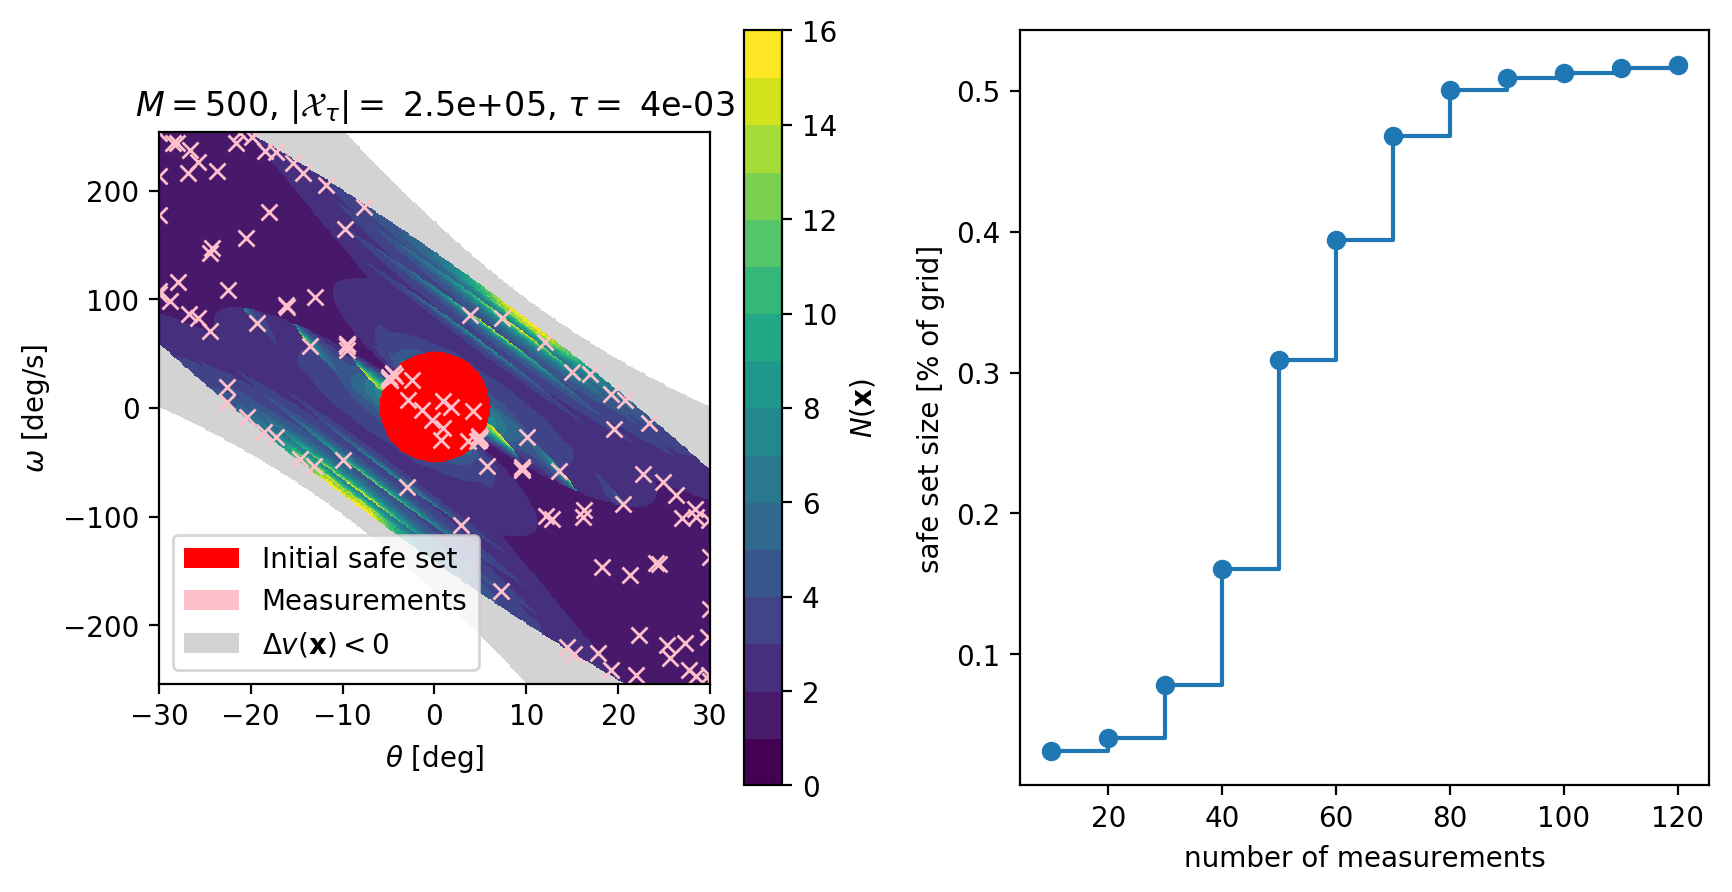

In [14]:
grid = lyapunov.discretization
feed_dict = lyapunov.feed_dict
feed_dict[states] = grid.all_points
feed_dict[tau] =  [[lyapunov.tau]]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=OPTIONS.dpi)
fig.subplots_adjust(wspace=0.25)
plot_limits = np.rad2deg(state_norm).reshape((-1, 1)) * grid.limits
axes[0].set_title(r'$M = {}$'.format(grid.num_points[0] - 1)
             + ', ' + r'$|\mathcal{X}_\tau| =$ ' + r'{:.1e}'.format(grid.nindex)
             + ', ' + r'$\tau =$ ' + r'{:.0e}'.format(np.sum(grid.unit_maxes) / 2))
axes[0].set_xlabel(r'$\theta$ [deg]')
axes[0].set_ylabel(r'$\omega$ [deg/s]')

axes[1].step(num_measurements, safe_set_fraction, 'o', where='post')
axes[1].set_xlabel(r'number of measurements')
axes[1].set_ylabel(r'safe set size [% of grid]')

# Decrease region for the true dynamics
decrease_region = (dv.eval(feed_dict) < 0).reshape(grid.num_points)
cmap = binary_cmap('lightgrey')
im = axes[0].imshow(decrease_region.T, origin='lower', extent=plot_limits.ravel(), aspect=plot_limits[0, 1] / plot_limits[1, 1], cmap=cmap, vmin=0, vmax=None)

# Refinement N(x) used; colorbar shown only if the discretization is adaptive
N = np.copy(lyapunov._refinement)
N[N == 0] = -1 # for color only

z = N.reshape(grid.num_points)
cmap = plt.get_cmap('viridis', lut=N_max)
cmap.set_over('gold')
cmap.set_under((1., 1., 1., 0.))
im = axes[0].imshow(z.T, origin='lower', extent=plot_limits.ravel(), aspect=plot_limits[0, 1] / plot_limits[1, 1], cmap=cmap, vmin=0, vmax=N_max)
if OPTIONS.use_adaptive_grid:
    cbar = fig.colorbar(im, ax=axes[0], label=r'$N({\bf x})$', ticks=np.arange(0, N_max + 1, 2))

# Initial safe set
initial_safe_set = lyapunov.initial_safe_set.reshape(grid.num_points)
cmap = binary_cmap('red')
im = axes[0].imshow(initial_safe_set.T, origin='lower', extent=plot_limits.ravel(), aspect=plot_limits[0, 1] / plot_limits[1, 1], cmap=cmap, vmin=None, vmax=None)

# Measurements
if isinstance(lyapunov.dynamics, safe_learning.UncertainFunction):
    # Skip origin data point
    X = norms.ravel() * lyapunov.dynamics.functions[0].X[1:, :grid.ndim]
    axes[0].plot(X[:, 0], X[:, 1], 'x', color='pink', mew=1, ms=6)

# Legend
colors = ['red', 'pink', 'lightgrey']
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in colors]
labels = [r'Initial safe set', r'Measurements'.format(len(X)), r'$\Delta v({\bf x}) < 0$']
axes[0].legend(proxy, labels, loc='lower left')

plt.show()
